In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np 
import os
import pandas as pd 
import sys
import seaborn as sns
sns.set(style='white',context='notebook',palette='deep')

if get_ipython():
  print("google colab")
  PROJECT_DIR=os.path.abspath(os.path.join(os.path.dirname('__file__'),'..'))
  from tqdm import tqdm_notebook as tqdm_notebook #토크나이저 출력이 한줄씩 나오는 것을 막기위함임
else:
  print("command shell envirment")
  PROJECT_DIR=os.path.abspath(os.path.join(os.path.dirname(__file__),'..'))
  from tqdm import tqdm
#sys.path에 PROJECT_DIR를 추가
sys.path.insert(0,PROJECT_DIR)

google colab


In [ ]:
!pwd

/content


In [ ]:
# 폴더 경로 : /content/drive/MyDrive/데이터캡스톤/CNN_DailyMail

In [ ]:
for dirname, _,filenames in os.walk('/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail'):
  for filename in filenames:
    print(os.path.join(dirname,filename))


/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/data_EDA.ipynb
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_1000_aug-LM_repeat-10.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_1000_aug-no_aug_repeat-10.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_1000_aug-rules_repeat-10.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_100_aug-LM_repeat-100.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_100_aug-no_aug_repeat-100.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_100_aug-rules_repeat-100.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_5000_aug-LM_repeat-2.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_5000_aug-no_aug_repeat-2.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_5000_aug-rules_repeat-2.csv
/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3

In [ ]:
# 컬럼데이타의 분포 플롯을 표시하기 위한 함수
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] #1에서50의 유니크한 값을 가지고 있는 컬럼을 선택
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [ ]:
# Correlation 매트릭스 함수
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # nan 값들 가진 놈들 다 떨굼
    df = df[[col for col in df if df[col].nunique() > 1]] # 하나 이상의 특징값을 가진 놈들은 살려둠
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [ ]:
# Scatter 와 density 플롯함수
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) #숫자로 된 놈들만 골라서
    # 데이터 프레임을 단수로 만드는 컬럼과 로우를 지움
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # 하나 이상의 특징값을 가진 놈들은 살려둠
    columnNames = list(df)
    if len(columnNames) > 10: # 컬럼수를 matrix inversion of kernel density plots를 위해 줄임
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [ ]:
nRowsRead = 1000 # 파일 전체를 다 읽어오기 위해서는 None을 입력
# cnn_dailymail-3.0.0_train_1000_aug-LM.csv 은 더 많은 행이 있지만 일단 앞의 1000개를 불러오자.
df1 = pd.read_csv('/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_1000_aug-LM_repeat-10.csv', delimiter=',', nrows = nRowsRead)

df1.dataframeName = 'cnn_dailymail-3.0.0_train_1000_aug-LM.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 4 columns


In [ ]:
df1.head(10)

,Unnamed: 0,article,highlights,id
0,0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,0001d1afc246a7964130f43ae940af6bc6c57f01
1,1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,00027e965c8264c35cc1bc55556db388da82b07f
3,3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,0002c17436637c4fe1837c935c04de47adb18e9a
4,4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,0003ad6ef0c37534f80b55b4235108024b407f0b
5,5,(CNN) -- Thousands on Saturday fled the area i...,"Humanitarian groups expect 4,000 refugees in o...",0004306354494f090ee2d7bc5ddbf80b63e80de6
6,6,(CNN) -- Four groups that advocate for immigra...,NEW: 4 groups announce legal challenge in Phoe...,0005d61497d21ff37a17751829bd7e3b6e4a7c5c
7,7,While Labor Day is the unofficial end of summe...,Labor Day is the unofficial end of summer and ...,0006021f772fad0aa78a977ce4a31b3faa6e6fe5
8,8,Gaza City (CNN) -- An Italian humanitarian act...,NEW: Autopsy indicates he had been dead for ho...,00083697263e215e5e7eda753070f08aa374dd45
9,9,(CNN) -- Renowned radio personality Casey Kase...,The radio personality was taken to a hospital ...,000940f2bb357ac04a236a232156d8b9b18d1667


In [ ]:
df1.article[0]

'It\'s official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It\'s a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but because he want

In [ ]:
df1.highlights[0]

'Syrian official: Obama climbed to the top of the tree, "doesn\'t know how to get down"\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .'

In [ ]:
plotPerColumnDistribution(df1,10,5)

<Figure size 2400x512 with 0 Axes>

In [ ]:
nRowsRead = 1000

df2 = pd.read_csv('/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_1000_aug-no_aug_repeat-10.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'cnn_dailymail-3.0.0_train_1000_aug-no_aug.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 4 columns


In [ ]:
df2.head(5)

,Unnamed: 0,article,highlights,id
0,0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,0001d1afc246a7964130f43ae940af6bc6c57f01
1,1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,00027e965c8264c35cc1bc55556db388da82b07f
3,3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,0002c17436637c4fe1837c935c04de47adb18e9a
4,4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,0003ad6ef0c37534f80b55b4235108024b407f0b


In [ ]:
plotPerColumnDistribution(df2, 10, 5)

<Figure size 2400x512 with 0 Axes>

In [ ]:
nRowsRead = 1000

df3 = pd.read_csv('/content/drive/MyDrive/데이터캡스톤/CNN_DailyMail/cnn_dailymail-3.0.0_train_1000_aug-rules_repeat-10.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'cnn_dailymail-3.0.0_train_1000_aug-rules.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 4 columns


In [ ]:
df3.head(5)

,Unnamed: 0,article,highlights,id
0,0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,0001d1afc246a7964130f43ae940af6bc6c57f01
1,1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,00027e965c8264c35cc1bc55556db388da82b07f
3,3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,0002c17436637c4fe1837c935c04de47adb18e9a
4,4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,0003ad6ef0c37534f80b55b4235108024b407f0b


In [ ]:
plotPerColumnDistribution(df3,10,5)

<Figure size 2400x512 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


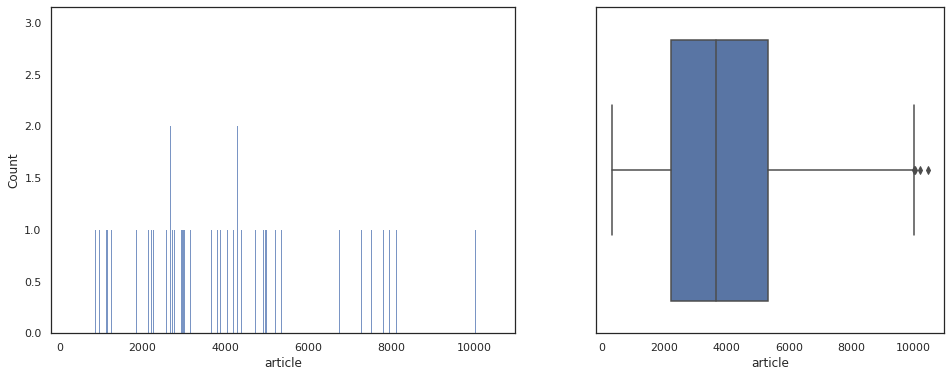

In [ ]:
#df1 기사의 문장 개수를 세어보자.
original_sent_counts=df1['article'].apply(len)

fig,axs=plt.subplots(1,2,figsize=(16,6),gridspec_kw=dict(width_ratios=[4,3]))
sns.histplot(original_sent_counts,binwidth=1,ax=axs[0])
sns.boxplot(original_sent_counts,ax=axs[1])


In [ ]:
original_sent_counts.describe()
#평균적으로 한 기사당 3946개의 문장으로 이루어져 있다...!

count     1000.000000
mean      3946.082000
std       2051.519725
min        310.000000
25%       2224.750000
50%       3669.000000
75%       5338.000000
max      10461.000000
Name: article, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


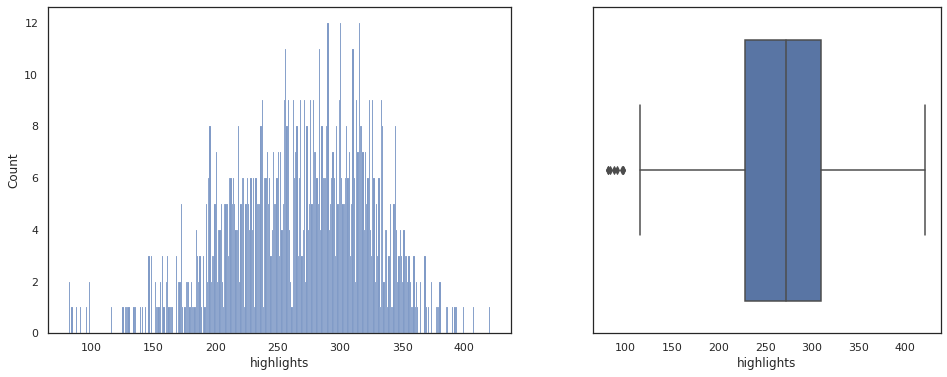

In [ ]:
#그렇다면 요약문장은?
highlights_sent_counts=df1['highlights'].apply(len)

fig,axs=plt.subplots(1,2,figsize=(16,6),gridspec_kw=dict(width_ratios=[4,3]))
sns.histplot(highlights_sent_counts,binwidth=1,ax=axs[0])
sns.boxplot(highlights_sent_counts,ax=axs[1])


In [ ]:
highlights_sent_counts.describe()
# 평균적으로 267개의 문장으로 이루어져 있다...!

count    1000.000000
mean      267.023000
std        56.415398
min        82.000000
25%       228.000000
50%       272.000000
75%       310.000000
max       421.000000
Name: highlights, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


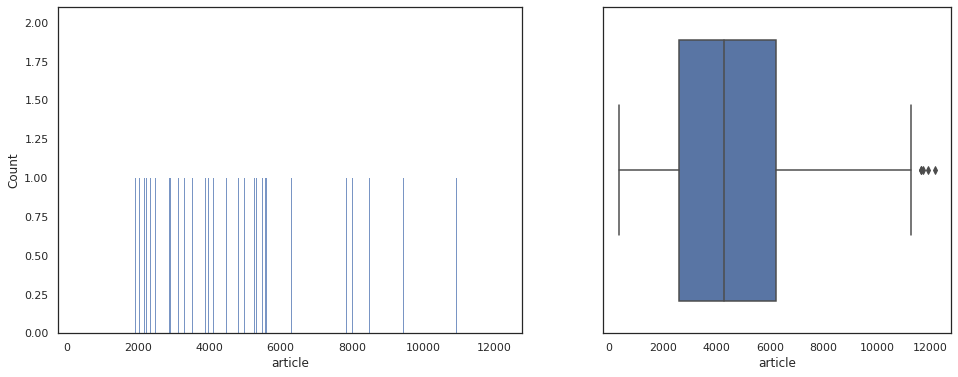

In [ ]:
original_word_counts=df1['article'].apply(lambda x:len(' '.join(x).split(' '))) # 공백을 기준으로 스플릿

fig,axs=plt.subplots(1,2,figsize=(16,6),gridspec_kw=dict(width_ratios=[4,3]))
sns.histplot(original_word_counts,binwidth=1,ax=axs[0])
sns.boxplot(original_word_counts,ax=axs[1])

In [ ]:
original_word_counts.describe()
#기사 원문은 평균적으로 4605개의 단어로 이루어져 있다...!

count     1000.000000
mean      4605.983000
std       2394.459901
min        361.000000
25%       2601.250000
50%       4278.000000
75%       6217.250000
max      12172.000000
Name: article, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


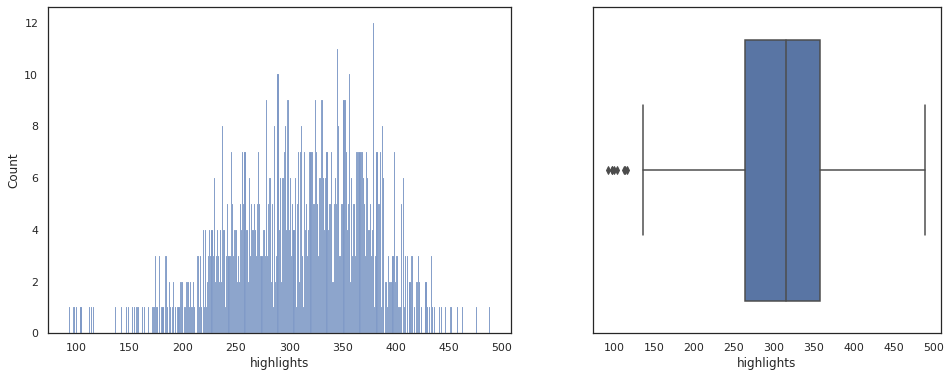

In [ ]:
highlights_word_counts=df1['highlights'].apply(lambda x:len(' '.join(x).split(' '))) # 공백을 기준으로 스플릿

fig,axs=plt.subplots(1,2,figsize=(16,6),gridspec_kw=dict(width_ratios=[4,3]))
sns.histplot(highlights_word_counts,binwidth=1,ax=axs[0])
sns.boxplot(highlights_word_counts,ax=axs[1])

In [ ]:
highlights_word_counts.describe()
#평균적으로 309개의 단어로 이루어져있다?
#앞서 267개의 문장으로 이루어졌음을 확인하였는데, 단어수가 309개인 것은 너무 적다. 무언가 문제가 있는것 같다.

count    1000.000000
mean      309.264000
std        65.267405
min        93.000000
25%       264.000000
50%       315.000000
75%       358.250000
max       489.000000
Name: highlights, dtype: float64

In [ ]:
df1['article'][3]

'Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. "I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case," Stancheva told CNN in a phone interview. She declined to cite the case or Burkhart\'s role in it. Stancheva said she and other doctors including a psychiatrist diagnosed Burkhart with "autism, severe anxiety, post-traumatic stress disorder and depression." The diagnosis was spelled out in a letter she wrote for the small-claims court case, Stancheva said. Stancheva, citing doctor-patient confidentiality, would not elaborate further, nor 

In [ ]:
df1['highlights'][3]

'NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: "autism, severe anxiety, post-traumatic stress disorder and depression"\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .'

In [ ]:
!pip install nlpy

In [ ]:
!git clone git://nlpy.git.sourceforge.net/gitroot/nlpy/nlpy

fatal: destination path 'nlpy' already exists and is not an empty directory.


In [ ]:
!pip install nltk


In [ ]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# nltk.download()
# 토크나이징
from nltk.tokenize import sent_tokenize
print(sent_tokenize(df1["highlights"][3])) # 문장단위로 토크나이징

['NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .', 'NEW: Diagnosis: "autism, severe anxiety, post-traumatic stress disorder and depression"\nBurkhart is also suspected in a German arson probe, officials say .', 'Prosecutors believe the German national set a string of fires in Los Angeles .']


In [ ]:
df1["highlights"][3] # 원 데이터 프레임을 변환하지는 않음

'NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: "autism, severe anxiety, post-traumatic stress disorder and depression"\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .'

In [ ]:
#정규표현식을 이용한 토큰화
from nltk.tokenize import RegexpTokenizer 

retokenize = RegexpTokenizer("[\w]+") #문자 또는 숫자가 1개 이상인 경우를 인식하므로, 문장에서 구두점을 제외하고 토큰화를 수행한다.
retokenize.tokenize(df1['highlights'][3])

['NEW',
 'A',
 'Canadian',
 'doctor',
 'says',
 'she',
 'was',
 'part',
 'of',
 'a',
 'team',
 'examining',
 'Harry',
 'Burkhart',
 'in',
 '2010',
 'NEW',
 'Diagnosis',
 'autism',
 'severe',
 'anxiety',
 'post',
 'traumatic',
 'stress',
 'disorder',
 'and',
 'depression',
 'Burkhart',
 'is',
 'also',
 'suspected',
 'in',
 'a',
 'German',
 'arson',
 'probe',
 'officials',
 'say',
 'Prosecutors',
 'believe',
 'the',
 'German',
 'national',
 'set',
 'a',
 'string',
 'of',
 'fires',
 'in',
 'Los',
 'Angeles']

In [ ]:
tokenizer=RegexpTokenizer("[\s]+", gaps=True) # gaps=True : 해당정규표현식을 토큰으로 나누기 위한 기준으로 사용한다는 뜻
retokenize.tokenize(df1['highlights'][3])     # \s+는 하나이상의 공백을 의미하므로, 기준을 정해주지 않았다면 공백들만 토큰으로 반환되었을 것이다.

['NEW',
 'A',
 'Canadian',
 'doctor',
 'says',
 'she',
 'was',
 'part',
 'of',
 'a',
 'team',
 'examining',
 'Harry',
 'Burkhart',
 'in',
 '2010',
 'NEW',
 'Diagnosis',
 'autism',
 'severe',
 'anxiety',
 'post',
 'traumatic',
 'stress',
 'disorder',
 'and',
 'depression',
 'Burkhart',
 'is',
 'also',
 'suspected',
 'in',
 'a',
 'German',
 'arson',
 'probe',
 'officials',
 'say',
 'Prosecutors',
 'believe',
 'the',
 'German',
 'national',
 'set',
 'a',
 'string',
 'of',
 'fires',
 'in',
 'Los',
 'Angeles']

In [ ]:
from nltk.tokenize import word_tokenize
word_tokenize(df1['article'][3])

['Los',
 'Angeles',
 '(',
 'CNN',
 ')',
 '--',
 'A',
 'medical',
 'doctor',
 'in',
 'Vancouver',
 ',',
 'British',
 'Columbia',
 ',',
 'said',
 'Thursday',
 'that',
 'California',
 'arson',
 'suspect',
 'Harry',
 'Burkhart',
 'suffered',
 'from',
 'severe',
 'mental',
 'illness',
 'in',
 '2010',
 ',',
 'when',
 'she',
 'examined',
 'him',
 'as',
 'part',
 'of',
 'a',
 'team',
 'of',
 'doctors',
 '.',
 'Dr.',
 'Blaga',
 'Stancheva',
 ',',
 'a',
 'family',
 'physician',
 'and',
 'specialist',
 'in',
 'obstetrics',
 ',',
 'said',
 'both',
 'Burkhart',
 'and',
 'his',
 'mother',
 ',',
 'Dorothee',
 ',',
 'were',
 'her',
 'patients',
 'in',
 'Vancouver',
 'while',
 'both',
 'were',
 'applying',
 'for',
 'refugee',
 'status',
 'in',
 'Canada',
 '.',
 '``',
 'I',
 'was',
 'asked',
 'to',
 'diagnose',
 'and',
 'treat',
 'Harry',
 'to',
 'support',
 'a',
 'claim',
 'explaining',
 'why',
 'he',
 'was',
 'unable',
 'to',
 'show',
 'up',
 'in',
 'a',
 'small-claims',
 'court',
 'case',
 ',',
 "''"

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 불용어처리
from nltk.corpus import stopwords

stop_words=set(stopwords.words('english'))

word_tokens=word_tokenize(df1['highlights'][3])

result=[]
for w in word_tokens:
  if w not in stop_words:
    result.append(w)

print(word_tokens)
print(result)


['NEW', ':', 'A', 'Canadian', 'doctor', 'says', 'she', 'was', 'part', 'of', 'a', 'team', 'examining', 'Harry', 'Burkhart', 'in', '2010', '.', 'NEW', ':', 'Diagnosis', ':', '``', 'autism', ',', 'severe', 'anxiety', ',', 'post-traumatic', 'stress', 'disorder', 'and', 'depression', "''", 'Burkhart', 'is', 'also', 'suspected', 'in', 'a', 'German', 'arson', 'probe', ',', 'officials', 'say', '.', 'Prosecutors', 'believe', 'the', 'German', 'national', 'set', 'a', 'string', 'of', 'fires', 'in', 'Los', 'Angeles', '.']
['NEW', ':', 'A', 'Canadian', 'doctor', 'says', 'part', 'team', 'examining', 'Harry', 'Burkhart', '2010', '.', 'NEW', ':', 'Diagnosis', ':', '``', 'autism', ',', 'severe', 'anxiety', ',', 'post-traumatic', 'stress', 'disorder', 'depression', "''", 'Burkhart', 'also', 'suspected', 'German', 'arson', 'probe', ',', 'officials', 'say', '.', 'Prosecutors', 'believe', 'German', 'national', 'set', 'string', 'fires', 'Los', 'Angeles', '.']


In [ ]:
# 대소문자 통일
text_lower=df1['highlights'][3].lower()
text_lower

'new: a canadian doctor says she was part of a team examining harry burkhart in 2010 .\nnew: diagnosis: "autism, severe anxiety, post-traumatic stress disorder and depression"\nburkhart is also suspected in a german arson probe, officials say .\nprosecutors believe the german national set a string of fires in los angeles .'

In [ ]:
# !pip install stanza
#스탄자는 왜인지 모르겠지만 에러가 뜬다.

In [ ]:
# import stanza

# nlp=stanza.Pipeline(lang='en',processors='tokenize')

# doc=nlp('This is a test sentence for stanza.This is anoter sentence.')

# for i, sentence in enumerate(doc.sentences):

  # print(f'===== Sentence {i+1} tokens =====')
  # print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

In [ ]:
!pip install tensorflow
!pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_text as text #텐서플로 토크나이져

In [ ]:
tokenizer=text.WhitespaceTokenizer()
tokens=tokenizer.tokenize(df1['highlights'][3])
tokens

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


<tf.Tensor: shape=(53,), dtype=string, numpy=
array([b'NEW:', b'A', b'Canadian', b'doctor', b'says', b'she', b'was',
       b'part', b'of', b'a', b'team', b'examining', b'Harry', b'Burkhart',
       b'in', b'2010', b'.', b'NEW:', b'Diagnosis:', b'"autism,',
       b'severe', b'anxiety,', b'post-traumatic', b'stress', b'disorder',
       b'and', b'depression"', b'Burkhart', b'is', b'also', b'suspected',
       b'in', b'a', b'German', b'arson', b'probe,', b'officials', b'say',
       b'.', b'Prosecutors', b'believe', b'the', b'German', b'national',
       b'set', b'a', b'string', b'of', b'fires', b'in', b'Los',
       b'Angeles', b'.'], dtype=object)>